In [40]:
#@title Files for Import
import_file = "mlwpy.py" #@param {type:"string"}

#import libraries
import re
import importlib

#create regex
find = re.compile(r"^(.*?)\..*")
# extract file name before .py ending
import_file_no_ext = re.search(find, import_file).group(1)

# copy file to the current notebook
!cp '/content/drive/MyDrive/Colab Notebooks/imports/{import_file}' .
# import module
module = importlib.import_module(import_file_no_ext)

# is there an __all__? if so import all
if '__all__' in module.__dict__:
    names = module.__dict__['__all__']
else:
    # otherwise import all names that don't begin with _
    names = [x for x in module.__dict__ if not x.startswith('_')]

# now bring them in
globals().update({k: getattr(module, k) for k in names})

print(f'Imported file: {import_file_no_ext}.py')

# set matplotlib to display inline
%matplotlib inline

Imported file: mlwpy.py


# Loading digits dataset

In [41]:
# setup
from mlwpy import *

digits = datasets.load_digits()
digits_ftrs, digits_tgt = digits.data, digits.target

diabetes = datasets.load_diabetes()
diabetes_ftrs, diabetes_tgt = diabetes.data, diabetes.target
iris = datasets.load_iris()
tts = skms.train_test_split(iris.data, iris.target,
                            test_size=.75, stratify=iris.target)
(iris_train_ftrs, iris_test_ftrs,
 iris_train_tgt, iris_test_tgt) = tts

# 12.2 Voting Ensembles

A simple way to form ensembles is the following:

(1) build several different models on the sam edataset and then, on a new example
(2) combine the predictions from the different models to get a single final prediction.

For regression problems we may take the eman or median. For classification, we can take a majority vote or perform other methods.

In [42]:
base_estimators = [linear_model.LogisticRegression(),
                   tree.DecisionTreeClassifier(max_depth=3),
                   naive_bayes.GaussianNB()]
base_estimators = [(get_model_name(m), m) for m in base_estimators]

ensemble_model = ensemble.VotingClassifier(estimators=base_estimators)
skms.cross_val_score(ensemble_model, digits_ftrs, digits_tgt)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


array([0.8167, 0.8111, 0.8552, 0.8858, 0.8579])

There are two points here, combining *different* types of models, for example, a linear regression and a decision tree regression, is called *stacking*. Combining models with different biases results in a less biased aggregate model.

## 12.3 Bagging and Random Forests

A more complicated way to combine models is to use *random forests* and rely on a technique called *bagging*. The word *bagging* is a portmanteau of the phrase *bootstrap aggregation*. *Aggregation* means combining, but we need to figure out what *bootstrap* means. 

For that we will describe how to calculate a simple statistic--the mean--using a *bootstrap* technique.



### 12.3.1 Bootstrapping

The basic idea of bootstrapping is to find a range of possibiliites in a single dataset. CV and bootstrapping are both instances of *resampling* techniques. Let's say we want to compute the mean from a dataset. There is a simple directly formula for the mean $(X) = \Sigma = \frac{x}{n}$. However, one calculated value of the mean could be misleading. For instance, how variable is our estimate of the mean? 

Often, we want to know how *wrong* we might be. Instead of being staisfied with a single value, we can ask about the *distribution* of the means we could compute from data that is like the da5taset. 

There are some theoretical answers that describe the distribution of the mean that you can find in any introductory statistics book. However, for some statistics, like fancy and trained classifiers, we don't have nice, pre-canned answers calculated by easy formulas. Bootstrapping provides a direct alternative. To figure out how to compute a bootstrapped value, let's look at some code and some graphics that explain the process.

**Sampling with and without Replacement** Before describing the bootstrap process, we need another idea. There are two ways to sample values from a collection of data. The first, *sampling without replacement*. In sampling without replacement, we do not replace the sample. We repeat this process until we recorded five total examples. Clearly, what we effect on the first draw has an effect on what is left for our second,  third, and subsequent draws. Sampling without replacement makes the choices *dependent* on what happened earlier, the examples are not independent of one another. In turn, affecting how statisticians let us talk about the sample.

Also, we can sample from a dataset by *sampling with replacement*: pulling  out an example from the dataset bag, recording its value, and *putting the example back in the bag*. Then we draw again and repeat until we have the number of samples we want. Sampling with replacement, as in Figure 12.3, gives us an *independent* sequence of examples.

How do we use bootstrapping to compute a *boostrap statistic*? We randomly sample our source dataset, *with replacement,* until we generate a new bootstrap sample with the same number of elements as our original. We compute our statistic of interest on that *bootstrap sample*. We do that several times and take the mean of the individual bootstrap sample statistics. Let's illustrate the idea with code. We start with the classic, nonbootstrap formula for the mean.

In [43]:
import numpy as np
dataset = np.array([1,5,10,10,17,20,35])
def compute_mean(data):
    return np.sum(data) / data.size
compute_mean(dataset)

14.0

Nothing too difficult there. One quick note, we could apply the calculation to the *entire* dataset and get the usual answer to the question, "What is the mean?" We could *also* apply `compute_mean` to other, tweaked forms of that dataset. We get different answers to different questions. Now, let's pivot to the bootstrap technique. We define a helper function to take a bootstrap sample--remember, it happens with replacement--and return it.

In [44]:
def bootstrap_sample(data):
    N = len(data)
    idx = np.arange(N)
    bs_idx = np.random.choice(idx, N,
                              replace=True) # default added for clarity
    return data[bs_idx]                              

Now we can see what several rounds of bootstrap sampling and the means for those samples look like:

In [45]:
bsms = []
for i in range(5):
    bs_sample = bootstrap_sample(dataset)
    bs_mean = compute_mean(bs_sample)
    bsms.append(bs_mean)

    print(bs_sample, '{:5.2f}'.format(bs_mean))

[ 5  1 35 20 17 10 35] 17.57
[10 17  5 17 35 35 10] 18.43
[ 5 10 35  1 10 17 35] 16.14
[ 1  1 10 17 17  5 10]  8.71
[20 10 17 10 17 35  1] 15.71


From the bootstrap sample means we can compute a single value--the mean of the means:

In [46]:
print('{:5.2f}'.format(sum(bsms) / len(bsms)))

15.31


Below the bootstrap calculatoin is rolled up into a single function:

In [47]:
def compute_bootstrap_statistic(data, num_boots, statistic):
    'repeatedly calculate statistic on num_boots bootstrap samples'
    bs_stats = [statistic(bootstrap_sample(data)) for i in range(num_boots)]
    # return the average of the calculated statistics
    return np.sum(bs_stats) / num_boots

bs_mean = compute_bootstrap_statistic(dataset, 100, compute_mean)
print('{:5.2f}'.format(bs_mean))    

13.71


### 12.3.2 From Bootstrapping to Bagging

When we create a *bagged learner*, we construct a much more convoluted statistic: a learner in the form of a trained model. In what sense is a learner a statistic? A statistic is any function of a group of data. The mean, median, min, and max are all calculations that we apply to a dataset to get a result. They are all statistics. Creating, fitting, and applying a learner to a new example--while a bit more complicated--is *just* calculating a result from a dataset.

In [48]:
def make_knn_statistic(new_example):
    def knn_statistic(dataset):
        ftrs, tgt = dataset[:,:-1], dataset[:,-1]
        knn = neighbors.KNeighborsRegressor(n_neighbors=3).fit(ftrs, tgt)
        return knn.predict(new_example)
    return knn_statistic        

The one oddity here is we used a closure. OUr statistic is calculated with respect to one specific new example. We need to hold taht test example fixed, so we can get down to a single value. Having done that trick, we have a calculation on the dataset, the inner function, `knn_statistic`, that we can use in the exact same way that we used `compute_mean`.


In [49]:
# have to slightly massage data for this scenario
# we use last example as our fixed test example
diabetes_dataset = np.c_[diabetes_ftrs, diabetes_tgt]

ks = make_knn_statistic(diabetes_ftrs[-1].reshape(1,-1))
compute_bootstrap_statistic(diabetes_dataset, 100, ks)

71.49

Just like computing the mean will give us different answers depending on the exact dataset we use, the returned value from `knn_statistic` will depend on the data we pass into it.

We can mimc that process and turn it into our basic algorithm for bagging:

1. Sample the data with replacement.
2. Create a model and traing it on that data.
3. Repeat.

To predict, we feed an example into each of the trained models and combine their predictions. The process, using decision trees as the component models, is shown in Figure 12.5.

<img src="https://drive.google.com/uc?id=1A5HHQ7iDA3fabpzHCB7I4epNaSSHstJA&authuser=scottminer1205%40gmail.com&usp=drive_fs"/>

**Figure 12.5** As with the bootstrapped mean, we sample the dataset and generate a decision tree from each subdataset. Every tree has a say in the final prediction.

Here's some pseudocode for a classification bagging system:

```python
def bagged_learner(dataset, base_model, num_models=10):
    # pseudo-code: needs tweaks to run
    models = []
    for n in num_models:
        bs_sample = np.random.choice(dataset, N, replace=True)
        models.append(base_model().fit(*bs_sample))

    return models

def bagged_predict_class(models, example):
    # take the most frequent (mode) predicted class as result
    preds = [m.predict(example) for m in models]
    return pd.Series(preds).mode()
```

We can talk about some practical concerns of bagging using the bias-variance terminology we introduced in Section 5.6. The process of combining many predictions is good at balancing out high variance: We're OK with *overfitting* in our base model. We overfit and then let the averaging smooth out the rough edges. Bagging does not help with *bias*, but is can help reduce variance. In practice, we want the `base_model` to have a low bias.


### 12.3.3 Through the Random Forest

Random forests (RFs) are a specific type of a bagged learner built on top of decision trees. RFs use a variation on the decision trees we've seen. Standard decision trees take the best-evaluated feature of *all* the features to create a decision node. On the other hands, RFs selection a random set of features and then take the best of that subset. The goal is to force trees to be different from each other. Even over a random selection of the examples, a single feature might be tightly related to teh target. This alpha feature would then be likely to be chosen as the top split point in each tree.

Instead of a single feature being the top decision point in many bootstrapped trees, we selectively ignore some features and introduce some randomness to shake things up. The randomness forces different trees to consider a variety of features. The original random forest algorithm relied on the same sort of majority voting that we described for bagging. However, `sklearn`'s versio nof RFs extracts class probabilities from each tree in the forest and then averages those to get a final answer: the class with the  highest average probability is the winner.

If we start with our `bagged_learner` code from above, we need to modify our tree-creation code--the component-model building step. It is a pretty simple modification which I've placed in *italics*:

0. *Randomly select a subset of features* for this tree to consider.
1. Evaluate the selected features and splits and pick the best feature-and-split.
2. Add a node to that tree representing the feature-split.
3. For each descendant, work with the matching data and either:
* If the targets are similar enough, return a predicted target.
* If not, return to step 1 and repeat.

Using the pseudocode as our base estimator, together with the `bagged_learner` code, gets us a quick prototype of a random forest learning system.

**Extreme Random Forests and Feature Splits** There is another variant, yet another bagged-tree (YABT), is called an *extreme random forest*. Here, *extreme* refers to adding yet another degree of randomness to the model creation process. Give a computer scientist an idea and they will apply it everywhere. In extreme random forests, we make the following change to the component-tree building process:

1. Select split points at random and take the best of those.

Therefore, in addition to randomly choosing what features are involved, we also determine what values are important by coin flipping. 




## 12.4 Boosting

The process of taking cards out of the deck is a bit like weighting the likelihood of seeing those cards but in an extreme way: it takes the probability down to zero. If I *really* wanted to be thorough, instead of removing the easy card, I could add duplicates of the hard cards. The effect is simlar: hard cards are seen more often and easy cards are seen less. The difference is the process is gradual.

We can apply this same idea, focusing on the hard examples, to a learning system. We start by fitting a simple model to some hard data. Not surprisingly, a lot of examples are wrong. We also do a few things right. We refocus on the harder examples and try again. The repeated process of focusing our efforts on harder examples, and considering the easier examples done--is at the heart of boosting.


### 12.4.1 Boosting Details

With boosting, we learn a simple model. Then, instead of resampling equally from the base dataset, we focus on the examples we got wrong and develop another model. We repeat the process until we are satisfied or run out of time. Boosting is a sequential method and the learners developed at later stages depend on what happened at earlier stages. While boosting can be applied to any learning model as the primitive component model, we often use *decision stumps*--decision trees with only one split point. Decision stumps have a depth of one. Decision stumps have a depth of one.

We have yet to talk aboutwhat learning with weighted data means. Think of it in two ways. If we want to perform weighted training and example A has twice the weight of example B, we simply duplicate example A twice in our training set and call it a day. The alternative is to incorporate the weighting in our error or loss measures. We weight errors by the example weight and get a *weighted error*. Next, we find the best knob settings with respect to the weighted errors, not raw errors. In a raw, pseudocode form, these steps look like:

1. Initialize example weights to \frac{1}{N} and *m* to zero.
2. Repeat until done:
    1. Increment *m*.
    2. Fit a new classifier (often a stump), *C_m,* to the weighted data.
    3. Compute weighted error on new classifier.
    4. The classifier weight, $wgt_m$, is function of weighted errors.
    5. Update example weights based on old example weights, classifier errors, and classifier weights.
3. For new example and *m* repeats, output a prediction from the majority vote of *C* weighted by wgt. 

We can take some massive liberties (don't try this at home!) and write some PYthonic pseudocode:

```python
def my_boosted_classifier(base_classifier, bc_args,
                          examples, targets, M):
    N = len(examples)
    data_weights = np.full(N, 1/N)
    models, model_weights = [], []

    for i in range(M):
        weighted_dataset = reweight((examples,targets),
                                    data_weights)

        this_model = base_classifier(*bc_args).fit(*weighted_dataset)

        errors = this_model.predict(examples) != targets
        weighted_error = np.dot(weights, errors)

        # magic reweighting steps
        this_model_wgt = np.log(1-weighted_error)/weighted_error
        data_weights *= np.exp(this_model_wgt * errors)
        data_weights /= data_weights.sum() # normalize to 1.0

        models.append(this_model)
        model_weights.append(this_model_wgt)

    return ensemble.VotingClassifier(models,
                                     voting='soft',
                                     weights=model_weights)
```                                             


We picked a value of `M` out of a hat. We only do `M` iterations. We could introduce a bit more flexibility here. `sklearn` stops its discrete AdaBoost, a specific boosting varietn, similar to what we used here, when either the accuracy hits 100% or `this_model` starts doing worse than a coin flip. 

Also, instead of reweights examples we could perform weighted bootstrap sample, which is done a different way to prioritize some data over another.

Boosting deals with *bias* in our learning systems. By combining simple, highly biased learners, boosting reduces the overall bias in the results. Boosting can *also* reduce variance.

In boosting, unlike bagging, we can't build the primitive models in parallel. We need to wait on the results of one pass so we can reweight our data and focus on the hard examples before we start our next pass.

#### 12.4.1.1 Improvements with Boosting Iterations

Two major boosting classifiers in `sklearn` are `GradientBoostingClassifier` and `AdaBoostClassifier`. Each can be told the maximum number of component estimators, our `M` argument to `my_boosted_classifier` to use through `n_estimators`. We leave details of the boosters to the end notes, but here are a few tidbits. AdaBoost is the classic forebearer of modern boosting algorithms. Gradient Boosting is a new twist that allows us to plug in different loss functions and get different models as a result. For exmaple, if we set `loss='exponential'` with the `GradientBoostingClassifier`, we get a model that is basically AdaBoost. The result gives code similar to `my_boosted_classifier.` 

Boosting is an iterative process. We can resonably ask how our model improves over the cycles of reweighting. `sklearn` makes it easy to access the progreess through `staged_predict`. `staged_predict` operates like `predict` except it follows the predictions made on examples at each step of the learning process. We need to convert the predictions into evaluation metrics if we want to quantify the progress.

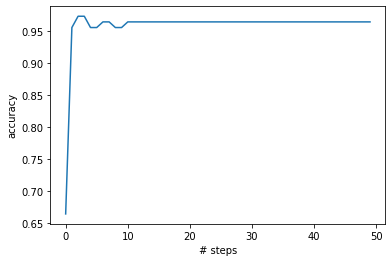

In [51]:
model = ensemble.AdaBoostClassifier()
stage_preds = (model.fit(iris_train_ftrs, iris_train_tgt)
                    .staged_predict(iris_test_ftrs))

stage_scores = [metrics.accuracy_score(iris_test_tgt, pred) for pred in stage_preds]
fig, ax = plt.subplots(1,1)
ax.plot(stage_scores)
ax.set_xlabel('# steps')
ax.set_ylabel('accuracy');                                     

## 12.5 Comparing the Tree-Ensemble Methods

Let's compare how the team-based methods work on the *digits* data. We start with two simple baselines: a single decision stump (equivalent to a `max_depth=1`tree) and a single `max_depth=3` tree. We also build 100 *different* forests with a number of tree stumps going from 1 to 100.

In [55]:
def fit_predict_score(model, ds):
    return skms.cross_val_score(model, *ds, cv=10).mean()

stump = tree.DecisionTreeClassifier(max_depth=1)
dtree = tree.DecisionTreeClassifier(max_depth=3)
forest = ensemble.RandomForestClassifier(max_features=1, max_depth=1)
tree_classifiers = {'stump' : stump, 'dtree' : dtree, 'forest': forest}

max_est = 100
data = (digits_ftrs, digits_tgt)
stump_score = fit_predict_score(stump, data)
tree_score = fit_predict_score(dtree, data)
forest_scores = [fit_predict_score(forest.set_params(n_estimators=n),
                                   data)
                for n in range(1,max_est+1)]


We can see the results graphically:

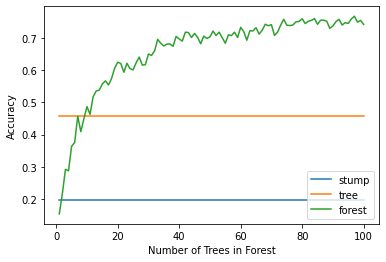

In [56]:
fig, ax = plt.subplots(1,1)
xs = list(range(1,max_est+1))
ax.plot(xs, np.repeat(stump_score, max_est), label='stump')
ax.plot(xs, np.repeat(tree_score, max_est), label ='tree')
ax.plot(xs, forest_scores, label='forest')

ax.set_xlabel('Number of Trees in Forest')
ax.set_ylabel('Accuracy')
ax.legend(loc='lower right');

Comparing forests to the two baselines shows that a single-stump forest acts a lot like a stump. But then, as the number of stumps grows, we quickly outperform even our moderately sized tree. Now, to see how the boosting methods progress over time *and* to make use of CV, to make sure we are comparing apples to apples, we need to manually manage a bit of the CV process. It is not complicated bu tslightly ugly. We need to generate the fold incides by hand with `StratifiedKFold` and then *use* those indices to select the proper parts of our dataset. We simply place this code inline, below, but that really obscures what we are trying to do.

In [ ]:
def my_manual_cv(dataset, k=10):
    'manually generate cv-folds from dataset '
    # expect ftrs, tgt tuple
    ds_ftrs, ds_tgt = dataset
    manual_cv = skms.StratifiedKFold(k).split(ds_ftrs,
                                              ds_tgt)
    for (train_idx, test_idx) in manual_cv:
        train_ftrs = ds_ftrs[train_idx]
        test_ftrs = ds_ftrs[test_idx]
        train_tgt = ds_tgt[train_idx]
        test_tgt = ds_tgt[test_idx]

        yield (train_ftrs, test_ftrs,
               train_tgt, test_tgt)

For this comparison, we use a `deviance` loss for our gradient boosting classifier. The result is that our classifier acts like logistic regression. We tinker with one important parameter to give `AdaBoostClassifier` a legitimate shot at sucess on the *digits* data. We adjust the `learning_rate` which is an additional factor, literally, a multiplier, on the weights of the estimators. You can think of it as multiplying `this_model_weight` in `my_boosted_classifier`.

In [59]:
AdaBC = ensemble.AdaBoostClassifier
GradBC = ensemble.GradientBoostingClassifier
boosted_classifiers = {'boost(Ada)' : AdaBC(learning_rate=2.0),
                       'boost(Grad)' : GradBC(loss="deviance")}

mean_accs = {}
for name, model in boosted_classifiers.items():
    model.set_params(n_estimators=max_est)
    accs = []
    for tts in my_manual_cv((digits_ftrs, digits_tgt)):
        train_f, test_f, train_t, test_t = tts
        s_preds = (model.fit(train_f, train_t)
                        .staged_predict(test_f))
        s_scores = [metrics.accuracy_score(test_t, p) for p in s_preds]
        accs.append(s_scores)
    mean_accs[name] = np.array(accs).mean(axis=0)

mean_acc_df = pd.DataFrame.from_dict(mean_accs,orient='columns')


Pulling out the individual, stage-wise accuracies is a bit annoying. But the end result is that we can compare the number of models we are combining between the different ensembles.

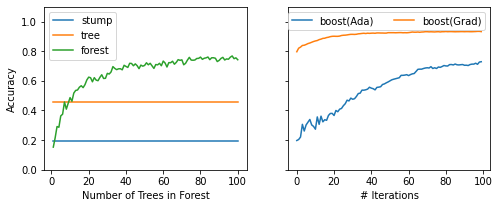

In [60]:
xs = list(range(1,max_est+1))
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,3),sharey=True)
ax1.plot(xs, np.repeat(stump_score, max_est), label='stump')
ax1.plot(xs, np.repeat(tree_score, max_est), label='tree')
ax1.plot(xs, forest_scores, label='forest')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Number of Trees in Forest')
ax1.legend()

mean_acc_df.plot(ax=ax2)
ax2.set_ylim(0.0, 1.1)
ax2.set_xlabel('# Iterations')
ax2.legend(ncol=2);

After adding more trees to the forest and letting more iterations pass for AdaBoost, the forest and AdaBoost have broadly similar performance (near 80% accuracy). However, the AdaBoost classifier does not seem to perform nearly as well as the GradientBoosting classifier. You can play around with some hyperparameters--`GridSearch` is seeming mighty useful about now--to see if you can improve any or all of these.

## Boosting

In [62]:
import xgboost
# gives us xgboost.SGBRegressor, sgboost.SGBClassifier
# which interface nicely with sklearn
# see docs at
# http://xgboost.readthedocs.io/en/latest/parameter.html
xgbooster = xgboost.XGBClassifier(objective='multi:softmax')
scores = skms.cross_val_score(xgbooster, iris.data, iris.target, cv=10)
print(scores)

[1.     0.9333 1.     0.9333 0.9333 0.9333 0.9333 0.9333 1.     1.    ]
